<a href="https://colab.research.google.com/github/dominique-nshimyimana/Car-State/blob/master/series_car_state_action_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car State-Action Prection 
#Colab: TensorFlow and GoogleDrive

In [1]:
%tensorflow_version 2.x
from google.colab import files
!git clone https://github.com/dominique-nshimyimana/DataSet.git
#%cd DataSet

Cloning into 'DataSet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


# NN state Evaluation

In [0]:
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, LeakyReLU
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.activations import tanh
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import Callback


class NeuralDynamics(Model):

    def __init__(self, input_size, out_size, training=False):

        super(NeuralDynamics, self).__init__()

        self.training = training
        self.out_size = out_size
        if type(input_size) is tuple:
          self.look_back = input_size[0]
          self.x_size = input_size[1]
        else:
          self.look_back = 1
          self.x_size = input_size

        self.nn_size = self.out_size*self.x_size  # self.out_size*self.look_back*self.x_size

        self.layer1 = Dense(6*self.nn_size, activation=LeakyReLU(alpha=1.0), kernel_regularizer=l1(0.1))
        self.layer2 = Dense(6*self.nn_size, activation=LeakyReLU(alpha=1.0), kernel_regularizer=l1(0.1))

        self.layer_state1a = Dense(12*self.nn_size, activation=LeakyReLU(alpha=1.0))

        self.layer_state1 = Dense(8*self.nn_size, activation=LeakyReLU(alpha=0.6), kernel_regularizer=l1(0.1))

        self.layer_state1b = Dense(4*self.nn_size, activation=LeakyReLU(alpha=0.6))
        self.layer_state1c = Dense(self.nn_size, activation=LeakyReLU(alpha=0.6))

        self.layer_state2 = Dense(self.out_size, kernel_regularizer=l1(0.1))

        self.layer_pose = Dense(2)
        self.layer_rest = Dense(4)

        self.dropout = Dropout(rate=0.2)

        self.flatten = Flatten()

    @tf.function
    def call(self, inputs):

        #state, action = inputs
        #if type(self.input_size) is tuple and self.state_size[0] != state.shape[0]:
        #  missing_zeros = self.state_size[0]-state.shape[0]
        #  paddings = tf.constant([[missing_zeros, 0], [0, 0]])
        #  state = tf.pad(state, paddings, "CONSTANT")

        #x = tf.identity(inputs)  # f.concat((state, action), axis=1)
        x = self.layer1(inputs)
        if self.training:
            x = self.dropout(x)
        x = self.layer2(x)
        if self.training:
            x = self.dropout(x)
        
        #x = concatenate([x1, x], axis=1)
        x = self.layer_state1a(x)

        x = self.flatten(x)

        x = self.layer_state1(x)
        if self.training:
            x = self.dropout(x)

        x = self.layer_state1b(x)
        x = self.layer_state1c(x)
        
        x = self.layer_state2(x)
        pose = self.layer_pose(tf.identity(x))
        rest = self.layer_rest(x)
        
        return concatenate([pose, rest])


class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.ep = 0

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < 180 and 9 < current%10:
            self.model.save("/content/DataSet/call{epoch}")
            
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Prepare Data

In [0]:
# Load dat from folder
# CSV form: Dataset
# Timestamp, x, y, yaw, xvel, yvel, omega, accel, brake, steering
def load_states_actions(data_dir, cutoff_beginning = 300, cutoff_end = 1000, norm=False, scale=False):
  data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and ".directory" not in f]

  xs_states = []
  xs_actions = []
  ys = []

  for f in data_files:
    print(f)
    data = np.loadtxt(f, delimiter=', ', skiprows=1, dtype=np.float32)[cutoff_beginning:-cutoff_end, :]
    x_states = [data[i, 1:-3] for i in range(len(data))]
    x_actions = [data[i, -3:] for i in range(len(data))]
    y = x_states[1:]
    x_states, x_actions = x_states[:-1], x_actions[:-1]
    xs_states += x_states
    xs_actions += x_actions
    ys += y

  xs_states = np.vstack(xs_states)
  xs_actions = np.vstack(xs_actions)
  ys = np.vstack(ys)

  if scale:
    scaler = MinMaxScaler()
    xs_states = scaler.fit_transform(xs_states)
    xs_actions = scaler.fit_transform(xs_actions)

  if norm:
    brake_mask = xs_actions[:, 0] < xs_actions[:, 1]
    xs_actions[brake_mask, 0] = -xs_actions[brake_mask, 1]
    xs_actions = xs_actions[:, [0, 2]]

    xs_states_shape_before = xs_states.shape[0]
    xs_std_before = np.std(xs_states, axis=0)
    ys_std_before = np.std(ys, axis=0)

    inliers = ~np.any(abs(xs_states - np.mean(xs_states, axis=0)) >= 3*np.std(xs_states, axis=0), axis=1)
    xs_states = xs_states[inliers]
    xs_actions = xs_actions[inliers]
    ys = ys[inliers]

    inliers = ~np.any(abs(ys - np.mean(ys, axis=0)) >= 3*np.std(ys, axis=0), axis=1)
    xs_states = xs_states[inliers]
    xs_actions = xs_actions[inliers]
    ys = ys[inliers]

  return xs_states, xs_actions, ys

# convert an array of values into a dataset matrix
# State(s) at a given time t (or time series until t) and Y is the state at the next time (t + 1).
def create_dataset(dataset, look_back=0, look_forward=1):
  dataX, dataY = [], []
  if look_back == 0 or look_forward == 0:
    return np.copy(dataset), np.copy(dataset)
  elif(look_back==-1 or look_forward==-1):
    return np.expand_dims(np.copy(dataset), axis=1), np.expand_dims(np.copy(dataset), axis=1)

  for i in range(len(dataset)-look_back-look_forward-1):
    dataX.append(dataset[i:i+look_back])
    dataY.append(dataset[i+look_back:i+look_back+look_forward])
  return np.array(dataX), np.array(dataY)

def create_Xy(Xsa, ylabel, look_back=1, look_forward=1):
  ''' s. import more_itertools and np.array(list(more_itertools.windowed(dx,n=3, step=1)))'''
  dataX, dataY = [], []
  if look_back == 0 or look_forward == 0:
    return np.copy(Xsa), np.copy(ylabel)
  elif(look_back==-1 or look_forward==-1):
    return np.expand_dims(np.copy(Xsa), axis=1), np.expand_dims(np.copy(ylabel), axis=1)

  for i in range(len(ylabel)-look_back-look_forward-1):
    dataX.append(np.copy(Xsa[i:i+look_back]))
    dataY.append(np.copy(ylabel[i+look_back:i+look_back+look_forward]))
  if look_forward == 1:
    return np.array(dataX), np.copy(ylabel)
  return np.array(dataX), np.array(dataY)
  
def takeSlice(arr, fr, to, name):
  result = arr[:,fr:to,:]
  print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
  return result

### Load Data

In [4]:
# Load Data
data_dir = "/content/DataSet/neuronyte_logging"
xs_states, xs_actions, ys = load_states_actions(data_dir=data_dir)

/content/DataSet/neuronyte_logging/NeuroNyte_1585748620.316643
/content/DataSet/neuronyte_logging/NeuroNyte_1585745385.311904


### Preparre and Look at Data ...

In [5]:
# Split data
x_states_train, x_states_test, x_actions_train, x_actions_test ,y_train, y_test = train_test_split(xs_states, xs_actions, ys, shuffle=False, test_size=0.10)

# How many steps/state in back from t and # How many steps/state in future/forward from t
look_back = 10
look_forward = 1

print(x_states_test.shape, x_actions_test.shape, y_test.shape)
print(x_states_train.shape, x_actions_train.shape, y_train.shape)
print(xs_states.shape, xs_actions.shape, ys.shape)

# reshape into X=t and Y=t+1 for states
if not True:
  X, y = create_dataset(x_states_train, look_back)
  x_states_test, y_test = create_dataset(x_states_test, look_back)
else:
  full_train = np.concatenate((xs_states, xs_actions), axis=1)
  X, y = create_Xy(full_train[:50000:], y_train[:50000:], look_back)
  full_test = np.concatenate((x_states_test, x_actions_test), axis=1)
  Xtest, ytest = create_Xy(full_test, y_test, look_back)

n = 25000 # Use only n data now (usefull, because it cove the trace)
t = 3 # Visualize X=t and Y=t+1
print(X[t])
print(y[t+1])
print(X.shape, y.shape)
Xshape, yshape = X.shape, y.shape

(105343, 6) (105343, 3) (105343, 6)
(948082, 6) (948082, 3) (948082, 6)
(1053425, 6) (1053425, 3) (1053425, 6)
[[0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]
 [0.      0.      2.96706 0.      0.      0.      0.      0.      0.     ]]
[0.      0.      2.96706 0.      0.      0.     ]
(49988, 10, 9) (50000, 6)


########## Look into Data ##########


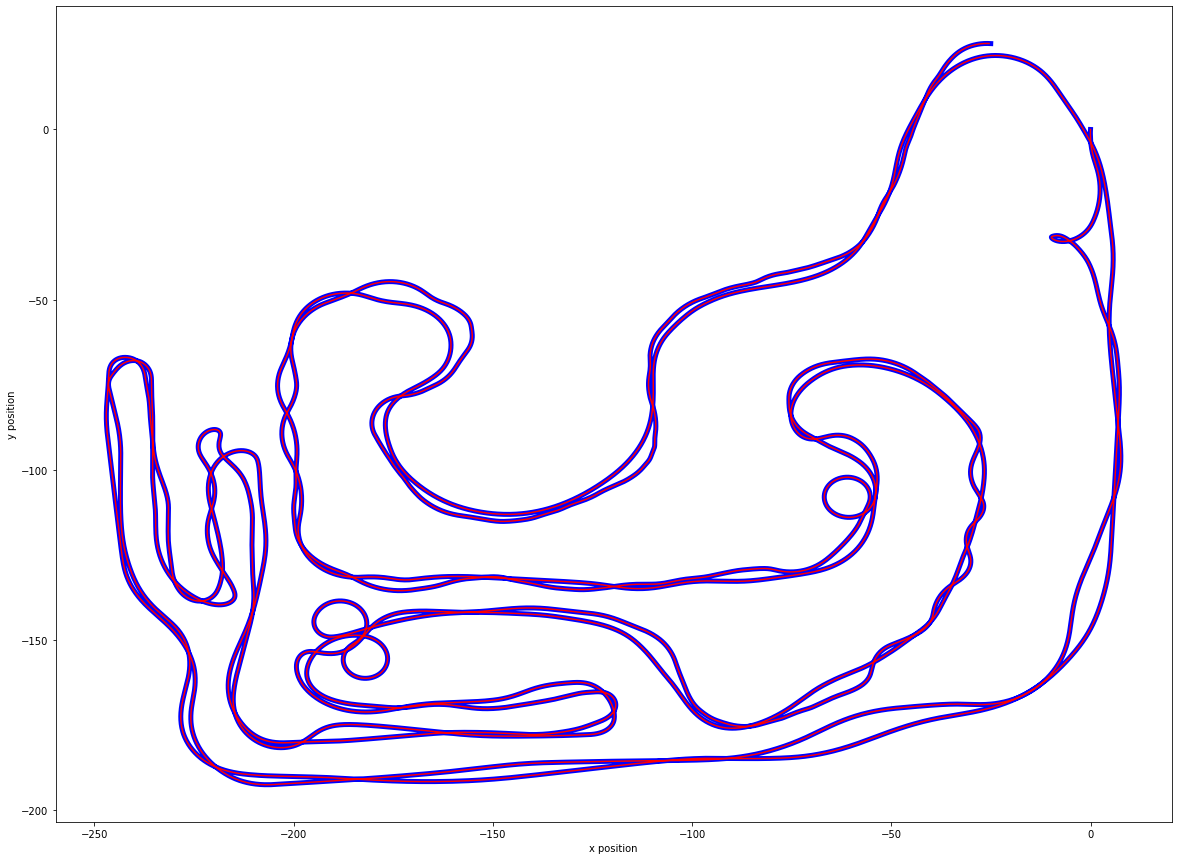

In [6]:
print('#'*10, "Look into Data",'#'*10)
if look_forward == 1:
  labels = y[:,:2]
else:
  labels = y[:,0:1,:2]
optionx  = X[:,0:1,:2]

plt.plot(*zip(*labels.reshape(-1,2)), 'b',linewidth=5)
plt.plot(*zip(*optionx.reshape(-1,2)),'r')
plt.ylabel('y position')
plt.xlabel('x position')

plt.gcf().set_size_inches(20, 15)
plt.show()

# Initialize Model

In [7]:
batchsize = 2000
decay = ExponentialDecay(0.0004, 20000, 0.99)
cosineDecay = tf.keras.experimental.CosineDecayRestarts(0.0004, 30, t_mul=2.0, m_mul=1.0, alpha=0.00001)
optimizer = tf.keras.optimizers.Adam(learning_rate=cosineDecay)

model = NeuralDynamics((look_back, X.shape[-1]),out_size=6, training=True)
EPOCHS = 2000
print('Model Initialized!', look_back, X.shape[-1])

Model Initialized! 10 9


# Training

In [0]:
print('X: ', X.shape, 'Y: ', y.shape)
callbacks= EarlyStoppingByLossVal(monitor='val_loss', value=37.00001, verbose=1)
# checkpoint
'''
filepath=join(mounted, "My Drive/NeuralModel/lstm_car_state/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit(X, Y, epochs=EPOCHS, validation_split=0.2, verbose=1, batch_size=20000, callbacks=callbacks_list)
'''
#history = model.fit(X, Y, epochs=EPOCHS, validation_split=0.2, verbose=1, batch_size=batchsize, metrics=['mse', 'mae', 'mape', 'cosine']))

model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.2, verbose=1, batch_size=batchsize, shuffle = False, callbacks=[callbacks])

model.save("/content/DataSet/seriesv1")

X:  (49988, 10, 9) Y:  (50000, 6)
Epoch 1/2000
20/20 [==============================] - 1s 32ms/step - loss: 14004.3184 - val_loss: 5635.8735
Epoch 2/2000
20/20 [==============================] - 0s 23ms/step - loss: 7062.8506 - val_loss: 6030.9048
Epoch 3/2000
20/20 [==============================] - 0s 23ms/step - loss: 5914.4111 - val_loss: 5172.2427
Epoch 4/2000
20/20 [==============================] - 0s 24ms/step - loss: 5429.7046 - val_loss: 5041.8340
Epoch 5/2000
20/20 [==============================] - 0s 23ms/step - loss: 5309.5654 - val_loss: 5050.7275
Epoch 6/2000
20/20 [==============================] - 0s 23ms/step - loss: 5143.8765 - val_loss: 4846.1431
Epoch 7/2000
20/20 [==============================] - 0s 23ms/step - loss: 4941.2407 - val_loss: 4744.3633
Epoch 8/2000
20/20 [==============================] - 0s 23ms/step - loss: 4838.8887 - val_loss: 4696.2778
Epoch 9/2000
20/20 [==============================] - 0s 23ms/step - loss: 4793.2622 - val_loss: 4676.5840
Ep

### Check at Training and Evaluating

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# eval_result = model.evaluate(object, x_states_test, y_test, batch_size = 1, verbose = 1, sample_weight = NULL, steps = NULL)

# Testing

In [0]:
rndIdx = 0 # 77962  # np.random.randint(0, len(y_test)-n-1)
Xtest_, ytest_ =   Xtest[rndIdx:n+rndIdx:], ytest[rndIdx:n+rndIdx:]
#Xtest_, ytest_ =   Xtest, ytest

print('Xtest: ', Xtest_.shape, 'ytest: ', ytest_.shape)
#result = model.predict((x_states_test, x_actions_test))
model.training = False
yhat = model.predict(Xtest_, batch_size=100)
print('Result: ', yhat.shape, rndIdx)

# Visualization of result

In [0]:
print('#'*10, "Look into Data",'#'*10)
# x, y, ... from shape=(...,...,{6 or 9})
if look_forward == 1:
  labels = y[:,:2]
else:
  labels = ytest_[:,0:1,:2]
predict  = yhat[:,:2]

plt.plot(*zip(*labels.reshape(-1,2)), 'b')
plt.plot(*zip(*predict.reshape(-1,2)),'r')
plt.ylabel('y position')
plt.xlabel('x position')
plt.suptitle("Prediction (red) vs Labels (blue)")
plt.gcf().set_size_inches(20, 15)
plt.show()

In [0]:
# Save and Download model ...
!zip -r /content/model1.zip /content/DataSet/seriesv1
!zip -r /content/model2.zip /content/DataSet/seriesv2
#files.download("/content/model1.zip")
#files.download("/content/model2.zip")
print("Download model1.zip and model2.zip an der linke Seite ..")

### Fine tune

In [0]:
# Use small batch
batchsize = 1000
EPOCHS = 50
decay = ExponentialDecay(0.0004, 20000, 0.99)
optimizer_exp = tf.keras.optimizers.Adam(learning_rate=decay)

model.training = False
model.compile(optimizer_exp, loss=tf.keras.losses.MeanSquaredError())  # metrics=['mse', 'mae', 'mape', 'cosine'])
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.3, verbose=1, batch_size=batchsize, shuffle = False)

model.save("/content/DataSet/seriesv2")

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [0]:
print('#'*10, 'Forcast after fine tuning ...','#'*10)
#rndIdx = np.random.randint(0, len(y_test)-n-1)
#Xtest_, ytest_ =  Xtest[rndIdx:n+rndIdx:], ytest[rndIdx:n+rndIdx:]
model.training = True
yhat = model.predict(Xtest_, batch_size=200)
print('Result: ', yhat.shape, rndIdx)

In [0]:
print('#'*10, "Vis after tuning ...",'#'*10)
if look_forward == 1:
  labels = y[:,:2]
else:
  labels = ytest_[:,0:1,:2]
predict  = yhat[:,:2]

plt.plot(*zip(*labels.reshape(-1,2)), 'b')
plt.plot(*zip(*predict.reshape(-1,2)),'r')
plt.ylabel('y position')
plt.xlabel('x position')
plt.suptitle("Prediction (red) vs Labels (blue)")
plt.gcf().set_size_inches(20, 15)
plt.show()

In [0]:
# Download model ...
#from google.colab import files
!zip -r /content/model1tuned.zip /content/DataSet/seriesv1
!zip -r /content/model2tuned.zip /content/DataSet/seriesv2
#files.download("/content/model1tuned.zip")
#files.download("/content/model21tuned.zip")
print("Download model1tuned.zip and model2tuned.zip an der linke Seite ..")